# ENVR 453: Groundwater Hydrology

## Uncertainty Quantification

Load the necessary packages

In [50]:
!pip install dataretrieval
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

Let's look again at data from the USGS site located on the Haw River in Haw River, NC.

Here is a link to the web interface: https://waterdata.usgs.gov/monitoring-location/02096500/#parameterCode=00065&period=P7D

In [26]:
### Grab the streamflow data and plot

### HAW RIVER AT HAW RIVER, NC
HRSiteID = '02096500'

### Dates for Start and End of Data
startDate = '2023-08-01'
endDate = '2023-08-20'

### Type of Data
### See https://github.com/DOI-USGS/dataretrieval-python for options
dataType = 'stat'

### Streamflow
param = '00060'

### Want Annual Statistics
reportType='annual'

### Grab Rain Data (inches)
HRRiverData = nwis.get_record(sites=HRSiteID, service=dataType,parameterCd=param,reportType='annual')

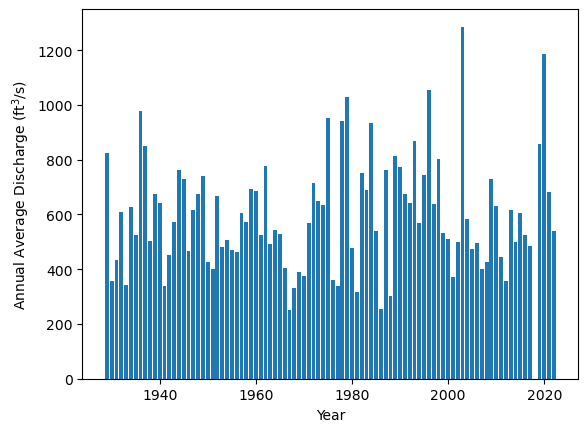

In [27]:
### Plot the Annual Average Streamflow Data for Haw River
fig, ax = plt.subplots()
plt.bar(HRRiverData['year_nu'],HRRiverData['mean_va'])
plt.xlabel('Year')
plt.ylabel('Annual Average Discharge (ft$^3$/s)')
plt.show()

## Generate Some Statistics of the Average Annual Streamflow

In [49]:
meanStreamFlow = np.mean(HRRiverData['mean_va'])
stdevStreamFlow = np.std(HRRiverData['mean_va'])
print(f'Mean Streamflow: {meanStreamFlow} ft^3/s')
print(f'Streamflow standard deviation: {stdevStreamFlow} ft^3/s')

Mean Streamflow: 600.6247311827957 ft^3/s
Streamflow standard deviation: 202.47654299606515 ft^3/s


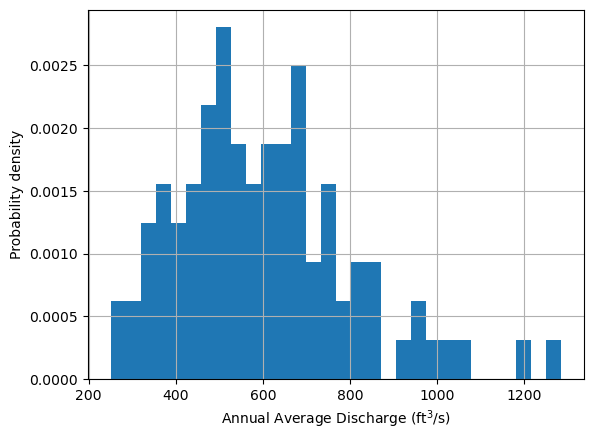

In [39]:
### Plot a histogram of the annual average streamflow data for Haw River
fig, ax = plt.subplots()
num_bins = 30
n, bins, patches = ax.hist(HRRiverData['mean_va'], num_bins, density=True)
ax.set_xlabel('Annual Average Discharge (ft$^3$/s)')
ax.set_ylabel('Probability density')
plt.title("Probability Distribution Function")
ax.grid(True)
plt.show()

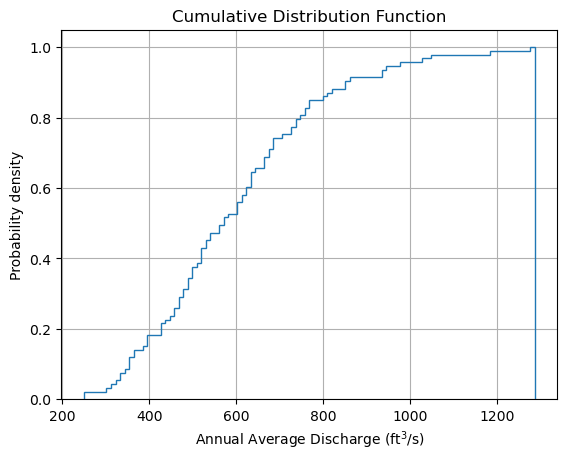

In [40]:
### Plot a histogram of the annual average streamflow data for Haw River
fig, ax = plt.subplots()
num_bins = 100
n, bins, patches = ax.hist(HRRiverData['mean_va'], num_bins, histtype='step', cumulative=True, density=True)
ax.set_xlabel('Annual Average Discharge (ft$^3$/s)')
ax.set_ylabel('Probability density')
plt.title("Cumulative Distribution Function")
ax.grid(True)
plt.show()

## Let's assume a lognormal distribution for streamflow data

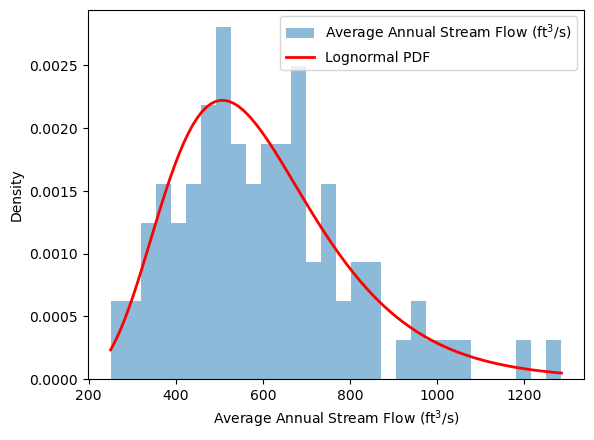

In [69]:
data = HRRiverData['mean_va']
shape, loc, scale = stats.lognorm.fit(data,floc=np.log(meanStreamFlow))
x = np.linspace(min(data), max(data), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)


### Plot PDF
plt.hist(data, bins=30, density=True, alpha=0.5, label='Average Annual Stream Flow (ft$^3$/s)')
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
plt.ylabel('Density')
plt.xlabel('Average Annual Stream Flow (ft$^3$/s)')
plt.legend()
plt.show()

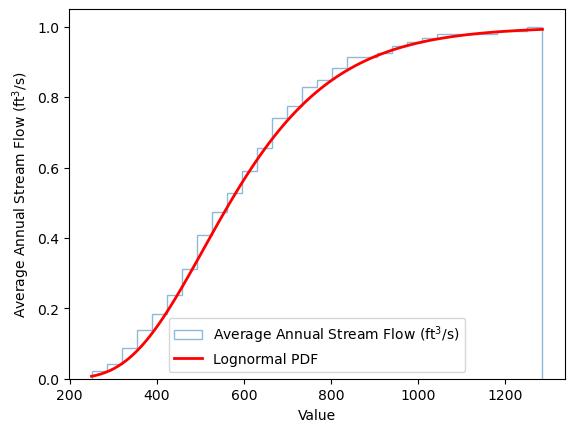

In [68]:
## Plot CDF
cdf = stats.lognorm.cdf(x, shape, loc, scale)
plt.hist(data, bins=30, density=True, alpha=0.5, label='Average Annual Stream Flow (ft$^3$/s)',histtype='step', cumulative=True)
plt.plot(x, cdf, 'r-', lw=2, label='Lognormal PDF')
plt.xlabel('Value')
plt.ylabel('Average Annual Stream Flow (ft$^3$/s)')
plt.title("Probability Distribution Function")
plt.title("Cumulative Distribution Function")
plt.legend()
plt.show()

In [71]:
### Check the fit with Kolmogrov-Smirnov Test
kstest_result = stats.kstest(data, 'lognorm', args=(shape, loc, scale))
print(kstest_result)

KstestResult(statistic=0.0486448641836823, pvalue=0.9727552320910259, statistic_location=605.3, statistic_sign=-1)
